In [18]:
import requests
import numpy as np
import pandas as pd
from scipy.stats import poisson
import datetime
from dateutil import parser
import sasoptpy as so
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from IPython.display import clear_output
import random
import string
import json
import subprocess
import time
import threading
from subprocess import Popen
import seaborn as sns

pd.set_option('display.max_columns', None)

# Fixture Generation Functions

In [19]:
def ordinal(n):
    n = int(n)
    if 10 <= n % 100 < 20:
        return str(n) + 'th'
    else:
        return  str(n) + {1 : 'st', 2 : 'nd', 3 : 'rd'}.get(n % 10, "th")

def generate_fixtures(custom_fixtures = None, exclude_past_games = True, last_date = None, display_ticker=True, display_unformatted=False):
    team_data_df = pd.read_csv('../data/team_data.csv')
    team_data_dict = team_data_df.set_index('fotmob_team').T.to_dict()
    pl_team_list = team_data_dict.keys()

    competition_dict = {'pl': {'id': '47', 'ccode3': 'GBR',},
                        'fa_cup': {'id': '132', 'ccode3': 'GBR',},
                        'league_cup': {'id': '133', 'ccode3': 'GBR',},
                        'ucl': {'id': '42', 'ccode3': 'GBR',},
                        'europa_league': {'id': '73', 'ccode3': 'GBR',},
                        'europa_conference_league': {'id': '10216', 'ccode3': 'GBR',},
                        }

    fixture_df = pd.DataFrame(columns=('comp', 'home_team', 'away_team', 'short_home_team', 'short_away_team', 'datetime_str', 'date_str', 'datetime_obj'))

    fantasy_format = 'TFF'

    # need to add other formats and competitions
    if fantasy_format == 'FPL':
        competition_subset_dict = {k:v for k, v in competition_dict.items() if k == 'pl'}
        period_separation = 'fpl_gw'
    elif fantasy_format == 'TFF':
        competition_subset_dict = {k:v for k, v in competition_dict.items() if k == 'pl'}
        period_separation = 'datetime_str'

    for key, params in competition_subset_dict.items():
        response = requests.get('https://www.fotmob.com/api/leagues', params=params)
        data = response.json()
        match_dict_list = data['matches']['allMatches']
        if key == 'pl':
            for match in match_dict_list:
                fotmob_home_team = match['home']['shortName']
                fotmob_away_team = match['away']['shortName']
                datetime_str = match['status']['utcTime']
                date_str = match['status']['utcTime'].split("T")[0]
                datetime_obj = parser.parse(datetime_str)
                # datetime_obj = datetime.datetime.strptime(datetime_str, '%Y-%m-%dT%H:%M:%SZ')
                # fpl_gw = match['roundName']

                short_home_team = team_data_dict[fotmob_home_team]['short_team']
                short_away_team = team_data_dict[fotmob_away_team]['short_team']
                fixture_df.loc[len(fixture_df)] = [key, fotmob_home_team, fotmob_away_team, short_home_team, short_away_team, datetime_str, date_str, datetime_obj]
    fixture_df['probability'] = 1
    fixture_df['is_custom'] = False

    # add custom fixtures, an example of the required format is commented out below
    # custom_fixtures = pd.DataFrame(columns=('comp', 'home_team', 'away_team', 'datetime_probs'))
    # custom_fixtures.loc[len(custom_fixtures)] = ['pl', 'MUN', 'FUL', {'2024-08-16T19:00:00Z':0.5, '2024-08-17T11:30:00Z':0.5}]
    # custom_fixtures.loc[len(custom_fixtures)] = ['pl', 'MUN', 'LIV', {'2024-08-16':0.5, '2024-08-17T12:30:00Z':0.5}]
    if custom_fixtures is not None:
        for index, row in custom_fixtures.iterrows():
            comp = row['comp']
            short_home_team = row['home_team']
            short_away_team = row['away_team']
            fixture_df = fixture_df.drop(fixture_df[(fixture_df['comp'] == comp) & (fixture_df['short_home_team'] == short_home_team) & (fixture_df['short_away_team'] == short_away_team)].index).reset_index(drop=True)
            for datetime_str, probability in row['datetime_probs'].items():
                datetime_obj = parser.parse(datetime_str)
                date_str = datetime.datetime.strftime(datetime_obj, "%Y-%m-%d")
                datetime_str = datetime.datetime.strftime(datetime_obj, '%Y-%m-%dT%H:%M:%SZ')
                datetime_obj = parser.parse(datetime_str)
                fotmob_home_team = team_data_df.loc[team_data_df['short_team'] == short_home_team, 'fotmob_team'].values[0]
                fotmob_away_team = team_data_df.loc[team_data_df['short_team'] == short_away_team, 'fotmob_team'].values[0]
                fixture_df.loc[len(fixture_df)] = [comp, fotmob_home_team, fotmob_away_team, short_home_team, short_away_team, datetime_str, date_str, datetime_obj, probability, True]


    fixture_df = fixture_df.sort_values(by='datetime_obj', ascending=True)

    # remove matches outside time bounds
    if exclude_past_games:
        today_datetime = datetime.datetime.today()
        for index, row in fixture_df.copy().iterrows():
            if row['datetime_str'] < datetime.datetime.strftime(today_datetime, '%Y-%m-%dT%H:%M:%SZ'):
                fixture_df = fixture_df.loc[fixture_df['datetime_str']!=row['datetime_str']]
        fixture_df.reset_index(drop=True)
    if last_date is not None:
        last_date_str = datetime.datetime.strftime(parser.parse(last_date) + datetime.timedelta(days=1), "%Y-%m-%d")
        for index, row in fixture_df.copy().iterrows():
            if row['datetime_str'] > last_date_str:
                fixture_df = fixture_df.loc[fixture_df['datetime_str']!=row['datetime_str']]
        fixture_df.reset_index(drop=True)

    gw_ref = pd.read_csv('../data/gw_ref.csv')
    fixture_df = pd.merge(left=fixture_df, right=gw_ref, on='date_str')

    num_unique_datetime = len(fixture_df[period_separation].unique())
    fixture_ticker = pd.DataFrame(columns=['team'] + ['short_team'] +list(fixture_df[period_separation].unique()))

    for team in pl_team_list:
        fixture_ticker.loc[len(fixture_ticker)] = [team] + [team_data_df.loc[team_data_df['fotmob_team']==team,'short_team'].values[0]] + [''] * num_unique_datetime

    for index, row in fixture_df.iterrows():
        prob_str = ''
        if row['probability'] != 1:
            prob_str = '*' + str(round(row['probability'],2))[1:]
        if row['home_team'] in pl_team_list:
            fixture_ticker.loc[fixture_ticker['team'] == row['home_team'], [row[period_separation]]] += '\n'+row['short_away_team'] + prob_str
        if row['away_team'] in pl_team_list:
            fixture_ticker.loc[fixture_ticker['team'] == row['away_team'], [row[period_separation]]] += '\n'+row['short_home_team'].lower() + prob_str

    # make formatted dataframe
    f_fixture_ticker = fixture_ticker.copy()
    datetime_str_cols = [x for i, x in enumerate(f_fixture_ticker.columns.tolist()) if len(x)>10]
    numeric_header =  [str(i-1) if 'team' not in x else x for i, x in enumerate(f_fixture_ticker.columns.tolist())]
    time_header = ['',''] + [parser.parse(x).strftime("%H:%M") for x in datetime_str_cols]
    daynum_header = ['',''] + [ordinal(parser.parse(x).strftime("%d")) for x in datetime_str_cols]
    weekday_header = ['',''] + [parser.parse(x).strftime("%a") for x in datetime_str_cols]
    gw_ref = pd.read_csv('../data/gw_ref.csv')
    tff_gw_header = ['',''] + ['GW' + str(gw_ref.loc[gw_ref['date_str']== x.split('T')[0], 'tff_gw'].values[0]) for x in datetime_str_cols]
    month_header = ['',''] + [parser.parse(x).strftime("%b") for x in datetime_str_cols]
    f_fixture_ticker.columns = [month_header, tff_gw_header, weekday_header, daynum_header, time_header, numeric_header]
    # Make color map dictionary and function
    team_data_df['h_gd'] = team_data_df['g_for']*team_data_df['home_adv'] - team_data_df['g_against']/team_data_df['home_adv']
    team_data_df['a_gd'] = team_data_df['g_for']/team_data_df['home_adv'] - team_data_df['g_against']*team_data_df['home_adv']
    color_ts = team_data_df[['short_team','h_gd', 'a_gd']].copy()
    min_gd = min(color_ts['h_gd'].values.tolist() + color_ts['a_gd'].values.tolist())*2.3
    max_gd = max(color_ts['h_gd'].values.tolist() + color_ts['a_gd'].values.tolist())#*1.8
    norm = matplotlib.colors.Normalize(vmin=min_gd, vmax=max_gd, clip=True)
    mapper = plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.viridis_r)
    color_ts['h_gd_color'] = color_ts['h_gd'].apply(lambda x: mcolors.to_hex(mapper.to_rgba(x)))
    color_ts['a_gd_color'] = color_ts['a_gd'].apply(lambda x: mcolors.to_hex(mapper.to_rgba(x)))
    h_teams = color_ts['short_team'].values.tolist()
    a_teams = [team.lower() for team in h_teams]
    teams = h_teams + a_teams
    team_gd = color_ts['a_gd_color'].values.tolist() + color_ts['h_gd_color'].values.tolist()
    color_dict = {teams[i]: team_gd[i] for i in range(len(teams))}
    def color_col(col, pattern_map, default=''):
        return np.select(
            [col.str.contains(k, na=False) for k in pattern_map.keys()],
            [f'background-color: {v}' for v in pattern_map.values()],
            default=default
        ).astype(str)
    # Apply styles
    f_fixture_ticker = f_fixture_ticker.style.apply(color_col,
                                                pattern_map=color_dict
                                                , subset=f_fixture_ticker.columns[2:]
                                                )
    f_fixture_ticker = f_fixture_ticker.set_table_styles([
                        {'selector': 'th.col_heading', 'props': 'text-align: left;'},
                        {'selector': 'th.col_heading.level0', 'props': 'font-size: 1em;'},
                        {'selector': 'td', 'props': 'text-align: center; font-weight: bold;'},
                    ], overwrite=False)
    f_fixture_ticker = f_fixture_ticker.set_properties(**{'color': 'white'},subset=(f_fixture_ticker.columns[2:]))

    if display_ticker:
        if display_unformatted:
            fixture_ticker = fixture_ticker.replace('\n',' ', regex=True)
            fixture_ticker.columns = [month_header, tff_gw_header, weekday_header, daynum_header, time_header, numeric_header]
            display(fixture_ticker)
        else:
            display(f_fixture_ticker)

    return {'f_fixture_ticker': f_fixture_ticker, 'unf_fixture_ticker': fixture_ticker, 'fixture_df': fixture_df}

# Modelling Functions

In [20]:
def player_data_gen(fixture_df):
    player_data = pd.read_csv('../data/player_data.csv')

    all_gw_list = sorted(fixture_df['fpl_gw'].unique())
    
    try:
        filepath = '../data/fplreview.csv'
        fplreview = pd.read_csv(filepath)
        fplreview = fplreview.rename(columns={'ID': 'fpl_id'})
        review_xmins = True
        print(f"Using minutes from {filepath}")
    except:
        review_xmins = False
        print(f"{filepath} not found, using default baseline minutes") 

    if review_xmins:
        review_gw_list = []
        for element in list(fplreview.columns.values):
            if '_xMins' in element:
                review_gw_list.append(int(element.split('_')[0]))
        review_gw_list.sort()
        for gw in all_gw_list:
            if gw < review_gw_list[0]:
                fplreview[f'{gw}_xMins'] = fplreview[f'{review_gw_list[0]}_xMins']
            elif gw > review_gw_list[-1]:
                fplreview[f'{gw}_xMins'] = fplreview[f'{review_gw_list[-1]}_xMins']
        player_data = pd.merge(player_data, fplreview.loc[:,['fpl_id'] + [f'{x}_xMins' for x in all_gw_list]], on=['fpl_id'], how='inner')

    else:
        for gw in all_gw_list:
            player_data[str(gw)+'_xMins'] = player_data['bl_xmin']
    return player_data


def eg_to_cs(eg=1.61):
    return poisson.cdf(k=0, mu=eg)


def pen_takers_from_fix(player_data, short_team = 'NEW', fpl_gw = 1, n_pens = 0.2):
    player_data_subset = player_data.loc[(player_data['short_team']==short_team) & (player_data['on_pens']>0) & (player_data[f'{fpl_gw}_xMins']>0)]
    pen_taker_dict = {player_row['tff_id']: (player_row[f'{fpl_gw}_xMins']**2.5)*(player_row['on_pens']**0.8)/95 for player_index, player_row in player_data_subset.iterrows()}
    value_sum = sum(pen_taker_dict.values())
    pen_taker_dict = {key: round(value*n_pens/value_sum, 3) for key, value in pen_taker_dict.items()}
    return pen_taker_dict

def np_scorers_from_fix(player_data, short_team = 'NEW', fpl_gw = 1, team_npg = 1.5):
    player_data_subset = player_data.loc[(player_data['short_team']==short_team) & (player_data['bl_npxg']>0.01) & (player_data[f'{fpl_gw}_xMins']>0)]
    npg_dict = {player_row['tff_id']: player_row[f'{fpl_gw}_xMins']*player_row['bl_npxg']*player_row['fin_skill']/95 for player_index, player_row in player_data_subset.iterrows()}
    npg_sum = sum(npg_dict.values())
    npg_dict = {key: round(value*team_npg/npg_sum, 3) for key, value in npg_dict.items()}
    return npg_dict

def assisters_from_fix(player_data, short_team = 'NEW', fpl_gw = 1, team_ag = 1.5):
    player_data_subset = player_data.loc[(player_data['short_team']==short_team) & (player_data['bl_a']>0.01) & (player_data[f'{fpl_gw}_xMins']>0)]
    a_dict = {player_row['tff_id']: player_row[f'{fpl_gw}_xMins']*player_row['bl_a']/95 for player_index, player_row in player_data_subset.iterrows()}
    a_sum = sum(a_dict.values())
    a_dict = {key: round(value*team_ag/a_sum, 3) for key, value in a_dict.items()}
    return a_dict

def list_players_in_team(player_data, short_team = 'NEW', fpl_gw = 1, xmin_cutoff=10):
    player_data_subset = player_data.loc[(player_data['short_team']==short_team) & (player_data[f'{fpl_gw}_xMins']>xmin_cutoff)]
    player_list = player_data_subset['tff_id'].to_list()
    return player_list

def read_probability_data(player_data, team_data_df, append_filename = ''):

    probability_dfs = pd.read_excel(f'../data/probability_data_raw{append_filename}.xlsx', sheet_name=None)
    probability_dfs['Assist'] = probability_dfs['Assist'].rename(columns={'eGoals/90': 'eAssists/90', 'Anytime Goal %': 'Anytime Assist %'})

    probability_dfs['Scorer'] = pd.merge(left=probability_dfs['Scorer'], right=player_data.loc[:,['fpl_id', 'tff_id']], left_on='ID', right_on='fpl_id')
    probability_dfs['Assist'] = pd.merge(left=probability_dfs['Assist'], right=player_data.loc[:,['fpl_id', 'tff_id']], left_on='ID', right_on='fpl_id')

    shortname_replace_dict = {row['review_short_team']: row['short_team'] for index, row in team_data_df.iterrows()}
    for key, df in probability_dfs.items():
        probability_dfs[key] = df.replace(shortname_replace_dict, regex=True)

    return probability_dfs

def add_aux_player_data(player_data, prob_dfs, own_team, opp_team, home_or_away='H', external_data_gws=[], gw=1, stat='Goals'):
    if gw not in external_data_gws or prob_dfs is None:
        return {}
    else:
        prob_df_dict = {'Goals':'Scorer', 'Assists':'Assist'}
        aux_df = prob_dfs[prob_df_dict[stat]]
        aux_df_subset = aux_df.loc[(aux_df['Team']==own_team) & (aux_df['Fixture']==f'({home_or_away}): {opp_team}') & (aux_df['GW']==gw)]
        return {row['tff_id']: row[f'e{stat}/90']*player_data.loc[player_data['tff_id']==row['tff_id'], f'{gw}_xMins'].values[0]/95 for index, row in aux_df_subset.iterrows()}

def add_team_lvl_projections(player_data, fixture_df, xmin_cutoff=10, aux_weight=0.8):

    team_data_df = pd.read_csv('../data/team_data.csv')
    if aux_weight > 0:
        try:
            prob_dfs = read_probability_data(player_data=player_data, team_data_df=team_data_df)
            external_data_gws = list(prob_dfs['CS']['GW'])
            print(f"Using external probability data with weight: {aux_weight}")
        except:
            external_data_gws = []
            prob_dfs = None
    else:
        external_data_gws = []
        prob_dfs = None

    fixture_df['home_g'] = 1.1
    fixture_df['home_cs'] = 0.5
    fixture_df['away_g'] = 1.1
    fixture_df['away_cs'] = 0.5

    fixture_df['home_pen_takers'] = pd.Series(dtype='object')
    fixture_df['away_pen_takers'] = pd.Series(dtype='object')

    fixture_df['home_np_scorers'] = pd.Series(dtype='object')
    fixture_df['away_np_scorers'] = pd.Series(dtype='object')

    fixture_df['home_assisters'] = pd.Series(dtype='object')
    fixture_df['away_assisters'] = pd.Series(dtype='object')

    fixture_df['home_players'] = pd.Series(dtype='object')
    fixture_df['away_players'] = pd.Series(dtype='object')

    fixture_df['home_aux_goals'] = pd.Series(dtype='object')
    fixture_df['away_aux_goals'] = pd.Series(dtype='object')
    fixture_df['home_aux_assists'] = pd.Series(dtype='object')
    fixture_df['away_aux_assists'] = pd.Series(dtype='object')

    for match_index, match_row in fixture_df.iterrows():
        home_g = team_data_df.loc[team_data_df['short_team'] == match_row['short_home_team'], 'g_for'].values[0] * team_data_df.loc[team_data_df['short_team'] == match_row['short_home_team'], 'home_adv'].values[0] * team_data_df.loc[team_data_df['short_team'] == match_row['short_away_team'], 'g_against_k'].values[0]
        away_g = team_data_df.loc[team_data_df['short_team'] == match_row['short_away_team'], 'g_for'].values[0] / team_data_df.loc[team_data_df['short_team'] == match_row['short_away_team'], 'home_adv'].values[0] * team_data_df.loc[team_data_df['short_team'] == match_row['short_home_team'], 'g_against_k'].values[0]
        fixture_df.at[match_index, 'away_g'] = away_g
        fixture_df.at[match_index, 'home_g'] = home_g

        if match_row['comp']=='pl' and match_row['fpl_gw'] in external_data_gws and not match_row['is_custom']:
            fixture_df.at[match_index, 'home_cs'] = eg_to_cs(away_g) * (1-aux_weight) + prob_dfs['CS'].loc[(prob_dfs['CS']['Team_Abbr']==match_row['short_home_team']) & (prob_dfs['CS']['Opp']==match_row['short_away_team']) & (prob_dfs['CS']['GW']==match_row['fpl_gw']), 'CS%'].values[0] * aux_weight
            fixture_df.at[match_index, 'away_cs'] = eg_to_cs(home_g) * (1-aux_weight) + prob_dfs['CS'].loc[(prob_dfs['CS']['Team_Abbr']==match_row['short_away_team']) & (prob_dfs['CS']['Opp']==match_row['short_home_team']) & (prob_dfs['CS']['GW']==match_row['fpl_gw']), 'CS%'].values[0] * aux_weight
        else:
            fixture_df.at[match_index, 'home_cs'] = eg_to_cs(away_g)
            fixture_df.at[match_index, 'away_cs'] = eg_to_cs(home_g)

        n_home_pens = team_data_df.loc[team_data_df['short_team'] == match_row['short_home_team'], 'pk_att_for'].values[0] * team_data_df.loc[team_data_df['short_team'] == match_row['short_home_team'], 'home_adv'].values[0] * team_data_df.loc[team_data_df['short_team'] == match_row['short_away_team'], 'pk_att_against_k'].values[0]
        n_away_pens = team_data_df.loc[team_data_df['short_team'] == match_row['short_away_team'], 'pk_att_for'].values[0] / team_data_df.loc[team_data_df['short_team'] == match_row['short_away_team'], 'home_adv'].values[0] * team_data_df.loc[team_data_df['short_team'] == match_row['short_home_team'], 'pk_att_against_k'].values[0]

        h_p_dict = pen_takers_from_fix(short_team = match_row['short_home_team'], fpl_gw = match_row['fpl_gw'], player_data = player_data, n_pens = n_home_pens) 
        fixture_df.at[match_index, 'home_pen_takers'] = h_p_dict
        a_p_dict = pen_takers_from_fix(short_team = match_row['short_away_team'], fpl_gw = match_row['fpl_gw'], player_data = player_data, n_pens = n_away_pens)
        fixture_df.at[match_index, 'away_pen_takers'] = a_p_dict

        # team goals adjusted for penalties, and the number of own goals per goal
        h_npg_dict = np_scorers_from_fix(short_team = match_row['short_home_team'], fpl_gw = match_row['fpl_gw'], player_data = player_data, team_npg = (home_g-(n_home_pens*0.79))*0.965)
        fixture_df.at[match_index, 'home_np_scorers'] = h_npg_dict
        a_npg_dict = np_scorers_from_fix(short_team = match_row['short_away_team'], fpl_gw = match_row['fpl_gw'], player_data = player_data, team_npg = (away_g-(n_away_pens*0.79))*0.965)
        fixture_df.at[match_index, 'away_np_scorers'] = a_npg_dict

        # team goals adjusted for number of assists per goal in telegraph in 23/24 (0.90045...)
        fixture_df.at[match_index, 'home_assisters'] = assisters_from_fix(short_team = match_row['short_home_team'], fpl_gw = match_row['fpl_gw'], player_data = player_data, team_ag = home_g*0.9005)
        fixture_df.at[match_index, 'away_assisters'] = assisters_from_fix(short_team = match_row['short_away_team'], fpl_gw = match_row['fpl_gw'], player_data = player_data, team_ag = away_g*0.9005)
        
        fixture_df.at[match_index, 'home_players'] = list_players_in_team(short_team = match_row['short_home_team'], fpl_gw = match_row['fpl_gw'], player_data = player_data, xmin_cutoff = xmin_cutoff)
        fixture_df.at[match_index, 'away_players'] = list_players_in_team(short_team = match_row['short_away_team'], fpl_gw = match_row['fpl_gw'], player_data = player_data, xmin_cutoff = xmin_cutoff)

        fixture_df.at[match_index,'home_aux_goals'] = add_aux_player_data(player_data=player_data, prob_dfs=prob_dfs, own_team=match_row['short_home_team'], opp_team=match_row['short_away_team'], home_or_away='H', external_data_gws=external_data_gws, gw=match_row['fpl_gw'], stat='Goals')
        fixture_df.at[match_index,'away_aux_goals'] = add_aux_player_data(player_data=player_data, prob_dfs=prob_dfs, own_team=match_row['short_away_team'], opp_team=match_row['short_home_team'], home_or_away='A', external_data_gws=external_data_gws, gw=match_row['fpl_gw'], stat='Goals')
        fixture_df.at[match_index,'home_aux_assists'] = add_aux_player_data(player_data=player_data, prob_dfs=prob_dfs, own_team=match_row['short_home_team'], opp_team=match_row['short_away_team'], home_or_away='H', external_data_gws=external_data_gws, gw=match_row['fpl_gw'], stat='Assists')
        fixture_df.at[match_index,'away_aux_assists'] = add_aux_player_data(player_data=player_data, prob_dfs=prob_dfs, own_team=match_row['short_away_team'], opp_team=match_row['short_home_team'], home_or_away='A', external_data_gws=external_data_gws, gw=match_row['fpl_gw'], stat='Assists')

    fixture_df = fixture_df.round(2)

    return fixture_df

def tff_ev_calc(player_dict, opp_dict, team_dict, fpl_gw=1, e_npg=0.3, e_pen=0.01, e_assists=0.3, cs=0.2, ga=1.5, aux_goal_dict={}, aux_assist_dict={}, aux_weight=0.8):

    xmin = player_dict[f'{fpl_gw}_xMins']
    x_95s = xmin/95
    p_start = (0.5)*(0.5 + np.cbrt((x_95s-0.5)/4)) + (0.5)*x_95s
    p_sub = (1-p_start) * x_95s

    ev = 0
    ev += 2 * p_start
    ev += 1 * p_sub

    e_goals = e_npg + e_pen*player_dict['fin_skill']*0.79
    ev += 5 * (e_goals*(1-aux_weight) + aux_goal_dict.get(player_dict['tff_id'], e_goals)*aux_weight)

    ev -= 2 * e_pen / player_dict['fin_skill'] * 0.21
    ev += 3 * (e_assists*(1-aux_weight) + aux_assist_dict.get(player_dict['tff_id'], e_assists)*aux_weight)

    if player_dict['tff_position'] < 2.5:
        ev += 5 * cs * p_start * player_dict['bl_p_60_given_start']
        ev += 2 * cs * (p_start*(1-player_dict['bl_p_60_given_start']) + p_sub)
        # approximation of poisson cdf sum, coeffs: array([-0.01146325,  0.0888773 ,  0.34962138, -0.06239911,  0.0041391 ])
        mu_gc = ga * x_95s
        ev -= max((0.0041391*(mu_gc**4) - 0.06239911*(mu_gc**3) + 0.34962138*(mu_gc**2) + 0.0888773*mu_gc - 0.01146325), 0)
        if player_dict['tff_position'] == 1:
            # approximation of poisson cdf sum, coeffs: array([-0.05142347,  0.28689925,  0.07500592, -0.01004676,  0.00034356])
            mu_sv = player_dict['bl_sv_per_sot'] * opp_dict['sot_for'] * team_dict['sot_against_k'] * x_95s
            ev += max(0.00034356*(mu_sv**4) - 0.01004676*(mu_sv**3) + 0.07500592*(mu_sv**2) + 0.28689925*mu_sv - 0.05142347, 0)
            ev += 5 * opp_dict['pk_att_for'] * team_dict['pk_att_against_k'] * 0.11 * x_95s

    if player_dict['tff_position'] == 3:
        # approximation of poisson cdf sum, fbref tackles won adjusted for telegraph
        mu_tackle = player_dict['bl_tackle'] * opp_dict['tackle_against_k'] * x_95s * 1.7
        ev += (1-poisson.cdf(k=1, mu=mu_tackle)) + (1-poisson.cdf(k=3, mu=mu_tackle)) + (1-poisson.cdf(k=5, mu=mu_tackle)) + (1-poisson.cdf(k=7, mu=mu_tackle)) \
            + (1-poisson.cdf(k=9, mu=mu_tackle)) + (1-poisson.cdf(k=11, mu=mu_tackle)) + (1-poisson.cdf(k=13, mu=mu_tackle)) + (1-poisson.cdf(k=15, mu=mu_tackle)) 
        # ev += max(0.00034356*(mu_tackle**4) - 0.01004676*(mu_tackle**3) + 0.07500592*(mu_tackle**2) + 0.28689925*mu_tackle - 0.05142347, 0)

    ev -= 1 * player_dict['bl_yc'] * opp_dict['yc_against_k'] * x_95s
    ev -= 3 * player_dict['bl_rc'] * opp_dict['rc_against_k'] * x_95s
    ev -= 3 * player_dict['bl_og'] * opp_dict['og_against_k'] * x_95s

    return ev

def generate_ev(custom_fixtures=None, exclude_past_games=True, last_date=None, xmin_cutoff=0, display_model_output=True, aux_weight=0.8):

    fixture_results_r = generate_fixtures(custom_fixtures=custom_fixtures, exclude_past_games=exclude_past_games, last_date=last_date, display_ticker=False)

    player_data = player_data_gen(fixture_df = fixture_results_r['fixture_df'])
    team_data = pd.read_csv('../data/team_data.csv')


    print('Adding team level projections')
    fixture_df = add_team_lvl_projections(player_data = player_data, fixture_df = fixture_results_r['fixture_df'], xmin_cutoff=xmin_cutoff, aux_weight=aux_weight)

    fixture_times = list(fixture_df['datetime_str'].unique())

    # initialize player ev dataframe
    pos_dict = {1: 'G', 2: 'D', 3: 'M', 4: 'F'}
    columns = ['tff_id', 'team', 'player', 'tff_pos', 'tff_cost'] + fixture_times + ['total_pts', 'ppm']
    ev_df = pd.DataFrame(columns = columns)
    for index, row in player_data.iterrows():
        ev_df.loc[len(ev_df)] = [int(row['tff_id']), row['short_team'], row['fpl_web_player'], pos_dict[row['tff_position']], row['tff_cost']] + [0] * (len(fixture_times)+2)

    print('Caculating player EV')
    # populate ev dataframe
    for match_index, match_row in fixture_df.iterrows():
        fix_prob = match_row['probability']
        datetime_str = match_row['datetime_str']
        fpl_gw = match_row['fpl_gw']
        for player_id in match_row['home_players']:
            player_dict = player_data.loc[player_data['tff_id']==player_id].to_dict('records')[0]
            team_dict = team_data.loc[team_data['short_team']==match_row['short_home_team']].to_dict('records')[0]
            opp_dict = team_data.loc[team_data['short_team']==match_row['short_away_team']].to_dict('records')[0]
            e_npg = match_row['home_np_scorers'].get(player_id, 0)
            e_pen = match_row['home_pen_takers'].get(player_id, 0)
            e_assists = match_row['home_assisters'].get(player_id, 0)
            cs = match_row['home_cs']
            ga = match_row['away_g']
            aux_goal_dict = match_row['home_aux_goals']
            aux_assist_dict = match_row['home_aux_assists']
            ev = tff_ev_calc(player_dict=player_dict, opp_dict=opp_dict, team_dict=team_dict, fpl_gw=fpl_gw, e_npg=e_npg, e_pen=e_pen, e_assists=e_assists, cs=cs, ga=ga, aux_goal_dict=aux_goal_dict, aux_assist_dict=aux_assist_dict, aux_weight=aux_weight)
            ev_df.loc[ev_df['tff_id'] == player_id, datetime_str] += ev * fix_prob
        for player_id in match_row['away_players']:
            player_dict = player_data.loc[player_data['tff_id']==player_id].to_dict('records')[0]
            team_dict = team_data.loc[team_data['short_team']==match_row['short_away_team']].to_dict('records')[0]
            opp_dict = team_data.loc[team_data['short_team']==match_row['short_home_team']].to_dict('records')[0]
            e_npg = match_row['away_np_scorers'].get(player_id, 0)
            e_pen = match_row['away_pen_takers'].get(player_id, 0)
            e_assists = match_row['away_assisters'].get(player_id, 0)
            cs = match_row['away_cs']
            ga = match_row['home_g']
            aux_goal_dict = match_row['away_aux_goals']
            aux_assist_dict = match_row['away_aux_assists']
            ev = tff_ev_calc(player_dict=player_dict, opp_dict=opp_dict, team_dict=team_dict, fpl_gw=fpl_gw, e_npg=e_npg, e_pen=e_pen, e_assists=e_assists, cs=cs, ga=ga, aux_goal_dict=aux_goal_dict, aux_assist_dict=aux_assist_dict, aux_weight=aux_weight)
            ev_df.loc[ev_df['tff_id'] == player_id, datetime_str] += ev * fix_prob

    ev_df['total_pts'] = ev_df.loc[:, fixture_times].sum(axis=1)
    ev_df['ppm'] = ev_df['total_pts'] / ev_df['tff_cost']
    ev_df = ev_df.sort_values(by='total_pts', ascending=False).reset_index(drop=True)
    for column in ev_df.columns:
        if column in fixture_times:
            ev_df[column] = ev_df[column].astype('float64')
    ev_df = ev_df.round(2)

    filepath = '../data/tff_model_output.csv'
    ev_df.to_csv(filepath, index=False)
    print(f'Player EV dataframe saved to {filepath}')
    if display_model_output:
        display(ev_df.head())

    return {'ev_df':ev_df, 'fixture_df':fixture_df}

# Optimization Functions

In [21]:
data = {'tff_pos': ['G', 'D', 'M', 'F'],
        'squad_min_play': [1, 3, 3, 1],
        'squad_max_play': [1, 5 ,5, 3]}
type_data = pd.DataFrame(data, index=[1,2,3,4])

def preprocess_dfs(ev_df, fixture_df, initial_squad=None, last_date=None, flatten_dates_after=None, 
                   total_pts_cutoff=None, ppm_cutoff=None, weekly_decay=None):

    fixture_map = fixture_df.copy()
    fixture_map = fixture_map.loc[:, ['datetime_str', 'date_str', 'datetime_obj', 'fpl_gw', 'tff_gw']]
    fixture_map = fixture_map.drop_duplicates(subset='datetime_str', keep="last").reset_index(drop=True)

    # remove matches after last date
    if last_date is not None:
        dropped_datetime_strs = []
        last_date_str = datetime.datetime.strftime(parser.parse(last_date) + datetime.timedelta(days=1), "%Y-%m-%d")
        for index, row in fixture_map.copy().iterrows():
            if row['datetime_str'] > last_date_str:
                dropped_datetime_strs += [row['datetime_str']]
                fixture_map = fixture_map.loc[fixture_map['datetime_str']!=row['datetime_str']]
        fixture_map.reset_index(drop=True)
        ev_df = ev_df.drop(dropped_datetime_strs, axis=1)
    
    # add matchtime labels
    fixture_map['matchtime'] = 1
    matchtime_counter = 1
    for index, row in fixture_map.copy().iterrows():
        fixture_map.loc[index, 'matchtime'] = matchtime_counter
        matchtime_counter += 1

    # add decay column
    if weekly_decay is not None:
        first_date_str = list(fixture_map['date_str'])[0]
        daily_decay = weekly_decay ** (1/7)
        fixture_map['decay'] = 1
        for index, row in fixture_map.copy().iterrows():
            fixture_map.loc[index, 'decay'] = daily_decay**(parser.parse(row['date_str'])-parser.parse(first_date_str)).days

    # sum ev columns after flatten_dates_after into one column
    if flatten_dates_after is not None:
        flatten_date_str = datetime.datetime.strftime(parser.parse(flatten_dates_after) + datetime.timedelta(days=1), "%Y-%m-%d")
        removed_datetime_decays = {}
        for index, row in fixture_map.copy().iterrows():
            if row['datetime_str'] > flatten_date_str:
                fixture_map = fixture_map.loc[fixture_map['datetime_str']!=row['datetime_str']]
                removed_datetime_decays[row['datetime_str']] = row['decay']
        last_remaining_date_str = fixture_map.tail(1).loc[:,'datetime_str'].values[0]
        last_remaining_decay = fixture_map.tail(1).loc[:,'decay'].values[0]
        for removed_datetime_str, decay in removed_datetime_decays.items():
            ev_df[last_remaining_date_str] += ev_df[removed_datetime_str] * decay / last_remaining_decay
            ev_df = ev_df.drop(removed_datetime_str, axis=1)
        ev_df[last_remaining_date_str] = round(ev_df[last_remaining_date_str], 2)

    # remove players outside of pts and ppm cutoffs
    if initial_squad is None:
        initial_squad = []
    if total_pts_cutoff is not None:
        total_pts_cutoff = total_pts_cutoff * ev_df['total_pts'].max()
        ev_df = ev_df.loc[(ev_df['total_pts']>total_pts_cutoff) | (ev_df['tff_id'].isin(initial_squad))]
    if ppm_cutoff is not None:
        ppm_cutoff = ppm_cutoff * ev_df['ppm'].max()
        ev_df = ev_df.loc[(ev_df['ppm']>ppm_cutoff) | (ev_df['tff_id'].isin(initial_squad))]

    ev_df = ev_df.rename(columns={row['datetime_str']: f"{row['matchtime']}_pts" for index, row in fixture_map.iterrows()})

    fixture_map = fixture_map.set_index('matchtime')
    ev_df = ev_df.set_index('tff_id')
    
    return {'ev_df': ev_df, 'fixture_map': fixture_map}

def get_random_id(n):
    return ''.join(random.choice(string.ascii_letters + string.digits) for _ in range(n))

def read_squad_from_json(squad_name):
    with open('../data/tff_squads.json', 'r') as fp:
        data = json.load(fp)
    return data[squad_name]

def input_squad_and_save(squad=[], save_team_as=None):

    if squad==[] and save_team_as is not None:
        print('No players in team to save')
        return

    squad_info = ''
    invalidity_message = ''
    player_data = pd.read_csv('../data/player_data.csv')
    player_data['tff_id'] = player_data['tff_id'].astype(int)
    
    seen = set()
    dupes = [str(x) for x in squad if x in seen or seen.add(x)]
    if dupes != []:
        # display(dupes)
        invalidity_message += '\nDuplicates found in team: ' + ', '.join(dupes)
    for tff_id in squad:
        if tff_id not in list(player_data['tff_id']):
            invalidity_message += f'\ntff_id {tff_id} not found in player_data.csv'
    squad_data = player_data.loc[player_data['tff_id'].isin(squad)]
    squad_data = squad_data.sort_values(by='tff_position')
    squad_cost = round(squad_data['tff_cost'].sum(),1)
    if squad_cost > 50:
        invalidity_message += f'\nSquad is £{round(squad_cost-50,1)}m over budget'
    if len(squad_data) > 11:
        invalidity_message += f'\n{len(squad_data)-11} too many players in squad'
    squad_info = ''
    for key, value in {1:{'pos_label': 'goalkeepers', 'limit': 1},
                       2:{'pos_label': 'defenders', 'limit': 5},
                       3:{'pos_label': 'midfielders', 'limit': 5},
                       4:{'pos_label': 'forwards', 'limit': 3}}.items():
        pos_list = [f"{row['fpl_web_player']} ({row['tff_id']})" for index, row in squad_data.loc[squad_data['tff_position']==key].iterrows()]
        squad_info += '\n'+', '.join(pos_list)
        if len(pos_list) > value['limit']:
            invalidity_message += f"\n{len(pos_list)-value['limit']} too many {value['pos_label']} in squad"
    squad_info += f'\n\nSquad cost: £{squad_cost}m\n'
    print(squad_info)

    if invalidity_message != '':
        print('\nInvalid squad' + invalidity_message)
    elif save_team_as is not None:
        with open('../data/tff_squads.json', 'r') as fp:
            data = json.load(fp)
        data[save_team_as] = squad
        with open('../data/tff_squads.json', 'w') as fp:
            json.dump(data, fp)
        print(f'Valid squad saved as {save_team_as}')
    return

def view_squad(squad_name = 1):
    squad = read_squad_from_json(squad_name)
    input_squad_and_save(squad=squad, save_team_as=None)
    return

In [22]:
def solve_tff_mp(ev_df, fixture_df, initial_squad, last_date=None, flatten_dates_after=None, 
                 total_pts_cutoff=None, ppm_cutoff=None,
                 ta_tot=40, ta_gw=5, objective='regular', weekly_decay=0.85, transfer_cost=6.5, 
                 exclusions=None, keeps=None, force_transfer_in=None, force_transfer_out=None, no_transfer_mds=None, show_non_team_ev=False,
                 apply_noise=False, seed_val=None, magnitude=1, sim_number=1,
                 show_solve_results=True, solver_type='highs', presolve='on', use_cmd=True, time_limit=120):
    
    if isinstance(initial_squad, str):
        
        initial_squad = read_squad_from_json(initial_squad)
        print('Initial team:')
        input_squad_and_save(squad=initial_squad, save_team_as=None)
    
    if objective == 'regular':
        weekly_decay = 1

    if show_solve_results:
        print(f'{len(ev_df)} players before ev cutoff')
    preprocessing_output = preprocess_dfs(ev_df, fixture_df, initial_squad=initial_squad, last_date=last_date, flatten_dates_after=flatten_dates_after, 
                                          total_pts_cutoff=total_pts_cutoff, ppm_cutoff=ppm_cutoff, weekly_decay=weekly_decay)
    ev_df = preprocessing_output['ev_df']
    if show_solve_results:
        print(f'{len(ev_df)} players after ev cutoff')
    fixture_map = preprocessing_output['fixture_map']
    
    horizon = len(fixture_map)
    problem_id = get_random_id(5)
    problem_name = f'tff_mp_h{horizon}_regular' if objective == 'regular' else f'tff_mp_h{horizon}_o{objective}_d{weekly_decay}'
    
    # Sets
    players = ev_df.index.tolist()
    element_types = type_data.index.tolist()
    matchtimes = list(fixture_map.index)
    all_matchtimes = [matchtimes[0]-1] + matchtimes
    tff_gameweeks = list(fixture_map['tff_gw'].unique())
    gw_transfer_allowance = {w: 5 for w in tff_gameweeks}
    gw_transfer_allowance[tff_gameweeks[0]] = min(ta_gw,5)

    if apply_noise:
        rng = np.random.default_rng(seed = seed_val)
        ev_df['total_pts'] = 0
        player_df = pd.read_csv('../data/player_data.csv')
        player_df = player_df[['tff_id', 'noise_factor']]
        ev_df = pd.merge(ev_df,player_df,on='tff_id').set_index('tff_id')
        if flatten_dates_after is None:
            for m in matchtimes:
                noise = ev_df[f'{m}_pts'] * 0.15 * rng.standard_normal(size = len(ev_df)) * magnitude
                ev_df[f'{m}_pts'] = ev_df[f'{m}_pts'] + round(noise,2)
                ev_df[f'{m}_pts'] = np.maximum(ev_df[f'{m}_pts'], 0)
                ev_df['total_pts'] += ev_df[f'{m}_pts']
        else:
            # Noise not applied to column representing multiple match periods
            for m in matchtimes[:-1]:
                noise = ev_df[f'{m}_pts'] * 0.15 * rng.standard_normal(size = len(ev_df)) * magnitude
                ev_df[f'{m}_pts'] = ev_df[f'{m}_pts'] + round(noise,2)
                ev_df[f'{m}_pts'] = np.maximum(ev_df[f'{m}_pts'], 0)
                ev_df['total_pts'] += ev_df[f'{m}_pts']
            ev_df['total_pts'] += ev_df[f'{matchtimes[-1]}_pts']

    # Model
    model = so.Model(name = problem_name)

    # Variables
    squad = model.add_variables(players, all_matchtimes, name='squad', vartype=so.binary)
    transfer_in = model.add_variables(players, matchtimes, name='transfer_in', vartype=so.binary)
    transfer_out = model.add_variables(players, matchtimes, name='transfer_out', vartype=so.binary)
    
    # Dictionaries
    squad_type_count = {(t,m): so.expr_sum(squad[p,m] for p in players if ev_df.loc[p, 'tff_pos'] == type_data.loc[t, 'tff_pos']) for t in element_types for m in matchtimes}
    player_value = (ev_df['tff_cost']).to_dict()
    squad_value = {m: so.expr_sum(player_value[p] * squad[p,m] for p in players) for m in matchtimes}
    points_player_day = {(p,m): ev_df.loc[p, f'{m}_pts'] for p in players for m in matchtimes}
    squad_count = {m: so.expr_sum(squad[p, m] for p in players) for m in matchtimes}
    
    total_number_of_transfers = so.expr_sum(transfer_out[p,m] for p in players for m in matchtimes) 

    mt_number_of_transfers = {m: so.expr_sum(transfer_out[p,m] for p in players) for m in matchtimes}        
    gw_number_of_transfers = {w: so.expr_sum(mt_number_of_transfers[m] for m in matchtimes if int(fixture_map.loc[m, 'tff_gw']) == w) for w in tff_gameweeks}
    
    # Constraints: squad
    if initial_squad is not None:
        model.add_constraints((squad[p, 0] == 1 for p in initial_squad), name='initial_squad_players')
        model.add_constraints((squad[p, 0] == 0 for p in players if p not in initial_squad), name='initial_squad_others')
    else:
        initial_squad = []
    model.add_constraints((squad_count[m] == 11 for m in matchtimes), name='squad_count')    
    # Constraints: formation and budget
    model.add_constraints((squad_type_count[t,m] == [type_data.loc[t, 'squad_min_play'], type_data.loc[t, 'squad_max_play']] for t in element_types for m in matchtimes), name='valid_formation_1')
    model.add_constraints((squad_value[m] <= 50 for m in matchtimes), name='squad_budget')
    # Constraints: transfers
    model.add_constraints((squad[p,m] == squad[p,m-1] + transfer_in[p,m] - transfer_out[p,m] for p in players for m in matchtimes), name='squad_transfer_rel')
    model.add_constraint(total_number_of_transfers <= min(ta_tot,40), name = 'transfer_allowance')
    model.add_constraints((gw_number_of_transfers[w] <= gw_transfer_allowance[w] for w in tff_gameweeks), name = 'gw_transfer_allowance')
    if no_transfer_mds is not None:
        model.add_constraints((mt_number_of_transfers[m] == 0 for m in no_transfer_mds), name='no_transfer_matchdays')
    # Constraints: forced players and transfers
    if exclusions is not None:
        model.add_constraints((squad[e, m] == 0 for e in exclusions for m in matchtimes), name = 'force_exclude_players')
    if keeps is not None:
        model.add_constraints((squad[e, m] == 1 for e in keeps for m in matchtimes), name = 'force_keep_players')
    if force_transfer_in is not None:
        model.add_constraints((squad[force_transfer_in[e][0], force_transfer_in[e][1]] == 1 for e in list(range(len(force_transfer_in)))), name = 'force_transfer_in_players')
        model.add_constraints((squad[force_transfer_in[e][0], force_transfer_in[e][1]-1] == 0 for e in list(range(len(force_transfer_in)))), name = 'force_transfer_in_players_2')
    if force_transfer_out is not None:
        model.add_constraints((squad[force_transfer_out[e][0], force_transfer_out[e][1]] == 0 for e in list(range(len(force_transfer_out)))), name = 'force_transfer_out_players')
        model.add_constraints((squad[force_transfer_out[e][0], force_transfer_out[e][1]-1] == 1 for e in list(range(len(force_transfer_out)))), name = 'force_transfer_out_players_2')
    
    # Objective
    md_xp = {m: so.expr_sum(points_player_day[p,m] * (squad[p,m]) for p in players) for m in matchtimes}
    if objective == 'regular':
        eval_score = so.expr_sum(md_xp[m] + 0.000001*mt_number_of_transfers[m]*m for m in matchtimes) - total_number_of_transfers*transfer_cost
        model.set_objective(-eval_score, sense='N', name='total_regular_xp') 
    else:
        eval_score = so.expr_sum(md_xp[m] * fixture_map.loc[m, 'decay'] + 0.000001*mt_number_of_transfers[m]*m for m in matchtimes) - total_number_of_transfers*transfer_cost
        model.set_objective(-eval_score, sense='N', name='total_decay_xp')
    
    # Solve Step
    model.export_mps(filename=f'tmp/{problem_name}_{problem_id}_{sim_number}.mps')
    if solver_type == 'cbc':
        command = f'cbc tmp/{problem_name}_{problem_id}_{sim_number}.mps sec {time_limit} solve solu tmp/{problem_name}_{problem_id}_{sim_number}_sol.txt'
        # !{command}
        os.system(command)
        # Read the solution back to the file
        with open(f'tmp/{problem_name}_{problem_id}_{sim_number}_sol.txt', 'r') as f:
            for v in model.get_variables():
                v.set_value(0)
            for line in f:
                if 'objective value' in line:
                    continue
                words = line.split()
                var = model.get_variable(words[1])
                var.set_value(float(words[2]))
    else:
        command = f'highs --presolve {presolve} --model_file tmp/{problem_name}_{problem_id}_{sim_number}.mps --time_limit {time_limit} --solution_file tmp/{problem_name}_{problem_id}_{sim_number}_sol.txt'
        # use_cmd is set to True to prevent highs from halting mid-process. It can be set to False if this does not happen on your machine
        if use_cmd:
            def print_output(process):
                while True:
                    output = process.stdout.readline()
                    if 'Solving report' in output:
                        time.sleep(2)
                        process.kill()
                    elif output == '' and process.poll() is not None:
                        break
                    elif output:
                        print(output.strip())

            process = subprocess.Popen(command, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True)
            output_thread = threading.Thread(target=print_output, args=(process,))
            output_thread.start()
            output_thread.join()
        else:
            os.system(command)

        with open(f'tmp/{problem_name}_{problem_id}_{sim_number}_sol.txt', 'r') as f:
            for v in model.get_variables():
                v.set_value(0)
            cols_started = False
            for line in f:
                if not cols_started and "# Columns" not in line:
                    continue
                elif "# Columns" in line:
                    cols_started = True
                    continue
                elif cols_started and line[0] != "#":
                    words = line.split()
                    v = model.get_variable(words[0])
                    try:
                        if v.get_type() == so.INT:
                            v.set_value(round(float(words[1])))
                        elif v.get_type() == so.BIN:
                            v.set_value(round(float(words[1])))
                        elif v.get_type() == so.CONT:
                            v.set_value(round(float(words[1]),3))
                    except:
                        print("Error", words[0], line)
                elif line[0] == "#":
                    break
    
    total_xp = round(so.expr_sum(points_player_day[p,m] * (squad[p,m]) for p in players for m in matchtimes).get_value(), 2)
    eval_score = round(eval_score.get_value(), 2)
    
    # Generate a dataframe to display the solution
    plan = []
    for t in element_types:
        for p in players:
            if so.expr_sum(squad[p,m] + transfer_out[p,m] for m in matchtimes).get_value() >= 0.5 and ev_df.loc[p, 'tff_pos'] == type_data.loc[t, 'tff_pos']:
                lp = ev_df.loc[p]
                if p in initial_squad:
                    appendment = '*'
                else:
                    appendment = ''
                player_info = [p, lp['team'], lp['tff_pos'], lp['tff_cost'], lp['player']+appendment]
                for m in matchtimes:
                    current_points = round(points_player_day[p,m], 2)
                    if squad[p,m].get_value() > 0.5:
                        score = f'{current_points}'
                    elif show_non_team_ev and current_points > 0.2:
                        score = f'({current_points})'
                    else:
                        score = ''
                    player_info.append(score)
                plan.append(player_info)
    columns = ['ID','Team', 'Pos','Cost','Name']
    for m in matchtimes:
        columns.append(f"{m}")
    plan_df = pd.DataFrame(plan, columns=columns)
    plan_df = plan_df.replace(['0.0'],'-')
    plan_df = plan_df.replace(['0.0c'],'-')
    itb_row = ['','','','','ITB']
    for m in matchtimes:
        itb = 50 - squad_value[m].get_value()
        itb_row.append(itb)
    plan_df.loc[len(plan_df)] = itb_row
    numeric_header = plan_df.columns.tolist()
    time_header = 5*[''] + [parser.parse(row['datetime_str']).strftime("%H:%M") for index, row in fixture_map.iterrows()]
    daynum_header = 5*[''] + [ordinal(parser.parse(row['datetime_str']).strftime("%d")) for index, row in fixture_map.iterrows()]
    weekday_header = 5*[''] + [parser.parse(row['datetime_str']).strftime("%a") for index, row in fixture_map.iterrows()]
    tff_gw_header = 5*[''] + ['GW' + str(row['tff_gw']) for index, row in fixture_map.iterrows()]
    month_header = 5*[''] + [parser.parse(row['datetime_str']).strftime("%b") for index, row in fixture_map.iterrows()]
    plan_df.columns = [month_header, tff_gw_header, weekday_header, daynum_header, time_header, numeric_header]

    # make dataframe to record the players in a simulation
    plan = []
    if apply_noise:
        for t in element_types:
            for p in players:
                if so.expr_sum(squad[p,m] + transfer_out[p,m] for m in matchtimes).get_value() >= 0.5 and ev_df.loc[p, 'tff_pos'] == type_data.loc[t, 'tff_pos']:
                    lp = ev_df.loc[p]
                    player_info = [p, lp['team'], lp['tff_pos'], lp['tff_cost'], lp['player']]
                    for m in matchtimes:
                        if squad[p,m].get_value() > 0.5:
                            score = 1
                        else:
                            score = 0
                        player_info.append(score)
                    plan.append(player_info)
        columns = ['ID','Team', 'Pos','Cost','Name']
        for m in matchtimes:
            columns.append(f"{m}")
        players_in_sim = pd.DataFrame(plan, columns=columns)
    else:
        players_in_sim = None

    transfers_made = int(total_number_of_transfers.get_value())

    if use_cmd:
        clear_output(wait=True)

    if show_solve_results:
        display(plan_df)
        print(f'EV: {total_xp}\tEval score: {eval_score}\tTransfers made: {transfers_made}')
    
    return{'model': model, 'total_xp': total_xp, 'eval_score': eval_score, 'plan': plan_df, 'transfers_made': transfers_made, 'players_in_sim': players_in_sim, 'fixture_map': fixture_map}

In [23]:
# simulate many solves with noise
def solve_tff_mp_sim(ev_df, fixture_df, initial_squad, last_date=None, flatten_dates_after=None,
                       total_pts_cutoff=0.3, ppm_cutoff=0.5,
                       ta_tot=50, ta_gw=5, objective='regular', weekly_decay=0.85, transfer_cost=6.5, 
                       exclusions=None, keeps=None, force_transfer_in=None, force_transfer_out=None, no_transfer_mds=None,show_non_team_ev=False,
                       seed_val=None, nsims=5, magnitude=1, display_sim_results=True,
                       solver_type='highs', presolve='on', use_cmd=True, time_limit=120):
    
    if initial_squad is None:
        initial_squad = []
    transfer_sum = 0
    xp_sum = 0
    eval_sum = 0

    results_dict = {}
    for i in range(nsims):
        print(f"Running sim {i+1} of {nsims}...")
        results = solve_tff_mp(ev_df=ev_df, fixture_df=fixture_df, initial_squad=initial_squad, last_date=last_date, flatten_dates_after=flatten_dates_after, 
                 total_pts_cutoff=total_pts_cutoff, ppm_cutoff=ppm_cutoff,
                 ta_tot=ta_tot, ta_gw=ta_gw, objective=objective, weekly_decay=weekly_decay, transfer_cost=transfer_cost, 
                 exclusions=exclusions, keeps=keeps, force_transfer_in=force_transfer_in, force_transfer_out=force_transfer_out, no_transfer_mds=no_transfer_mds,show_non_team_ev=show_non_team_ev,
                 apply_noise=True, seed_val=seed_val, magnitude=magnitude,sim_number=i+1,
                 show_solve_results=False, solver_type=solver_type, presolve=presolve, use_cmd=use_cmd, time_limit=time_limit)
        results_dict[i] = results['plan']
        players_in_sim = results['players_in_sim']
        if i == 0:
            sensitivity_df = players_in_sim
        else:
            for index, row in results['players_in_sim'].iterrows():
                if row['ID'] in sensitivity_df['ID'].tolist():
                    sensitivity_df.loc[sensitivity_df['ID']==row['ID'], '1':] = sensitivity_df.loc[sensitivity_df['ID']==row['ID'], '1':] + row['1':]
                    continue
                else:
                    row_to_append = row.tolist()
                    sensitivity_df.loc[len(sensitivity_df)] = row_to_append
        clear_output(wait=True)
        transfer_sum += results['transfers_made']
        xp_sum += results['total_xp']
        eval_sum += results['eval_score']
    avg_trf = round(transfer_sum/nsims,2)
    avg_xp = round(xp_sum/nsims,2)
    avg_eval = round(eval_sum/nsims,2)
    sensitivity_df.loc[:,'1':] = sensitivity_df.loc[:,'1':] * 100 / nsims
    sensitivity_df.loc[:,'1':] = sensitivity_df.loc[:,'1':].astype(int)

    # Sort the dataframe by initial team and position
    sensitivity_df['max_ocuurences'] = 0
    sensitivity_df['init_team'] = 0
    sensitivity_df['pos_code'] = 0
    for index, row in sensitivity_df.iterrows():
        if row['Pos'] == 'G':
            sensitivity_df.loc[index,'pos_code'] = 1
        elif row['Pos'] == 'D':
            sensitivity_df.loc[index,'pos_code'] = 2
        elif row['Pos'] == 'M':
            sensitivity_df.loc[index,'pos_code'] = 3
        else:
            sensitivity_df.loc[index,'pos_code'] = 4
        if row['ID'] in initial_squad:
            sensitivity_df.loc[index,'init_team'] = 1
    sensitivity_df = sensitivity_df.sort_values(by=['pos_code', 'init_team'], ascending=[True, False])
    sensitivity_df.drop(['max_ocuurences', 'init_team', 'pos_code'], axis=1, inplace=True)
    sensitivity_df = sensitivity_df.reset_index(drop=True)
    
    fixture_map = results['fixture_map']
    numeric_header = sensitivity_df.columns.tolist()
    time_header = 5*[''] + [parser.parse(row['datetime_str']).strftime("%H:%M") for index, row in fixture_map.iterrows()]
    daynum_header = 5*[''] + [ordinal(parser.parse(row['datetime_str']).strftime("%d")) for index, row in fixture_map.iterrows()]
    weekday_header = 5*[''] + [parser.parse(row['datetime_str']).strftime("%a") for index, row in fixture_map.iterrows()]
    tff_gw_header = 5*[''] + ['GW' + str(row['tff_gw']) for index, row in fixture_map.iterrows()]
    month_header = 5*[''] + [parser.parse(row['datetime_str']).strftime("%b") for index, row in fixture_map.iterrows()]
    sensitivity_df.columns = [month_header, tff_gw_header, weekday_header, daynum_header, time_header, numeric_header]
    sens = sensitivity_df.copy()
    sens = sens.style.background_gradient(cmap="RdPu", subset=sensitivity_df.columns[5:]).format(precision=1)
    sens = sens.set_table_styles([
                        {'selector': 'th.col_heading', 'props': 'text-align: left;'},
                        {'selector': 'th.col_heading.level0', 'props': 'font-size: 1em;'},
                        {'selector': 'td', 'props': 'text-align: center; font-weight: bold;'},
                    ], overwrite=False)
    
    if display_sim_results:
        display(sens)
        print(f"Number of sims: {nsims}\tTransfer cost: {transfer_cost}\tNoise magnitude: {magnitude}\nAvg transfers made: {avg_trf}\t  EV: {avg_xp}\tEval: {avg_eval}")
                
    return {'sensitivity_df': sens, 'avg_trf': avg_trf, 'avg_xp': avg_xp, 'avg_eval': avg_eval, 'sensitivity_df_unformatted': sensitivity_df, 'results_dict': results_dict}

# Commands

In [24]:
cf_df = pd.DataFrame(columns=('comp', 'home_team', 'away_team', 'datetime_probs'))

# cf_df.loc[len(cf_df)] = ['pl', 'IPS', 'CRY', {'2024-12-03T19:30:00Z':1}]
# cf_df.loc[len(cf_df)] = ['pl', 'LEI', 'WHU', {'2024-12-03T20:15:00Z':1}]

fixture_results = generate_fixtures(custom_fixtures=cf_df, exclude_past_games=True, last_date=None, display_unformatted=False)

In [25]:
ev_results = generate_ev(custom_fixtures=cf_df, exclude_past_games=True, last_date='2025-01-26', xmin_cutoff=30, aux_weight=0)
ev_df = ev_results['ev_df']
fixture_df = ev_results['fixture_df']

Using minutes from ../data/fplreview.csv
Adding team level projections
Caculating player EV
Player EV dataframe saved to ../data/tff_model_output.csv


,tff_id,team,player,tff_pos,tff_cost,2024-11-02T12:30:00Z,2024-11-02T15:00:00Z,2024-11-02T17:30:00Z,2024-11-03T14:00:00Z,2024-11-03T16:30:00Z,2024-11-04T20:00:00Z,2024-11-09T15:00:00Z,2024-11-09T17:30:00Z,2024-11-09T20:00:00Z,2024-11-10T14:00:00Z,2024-11-10T16:30:00Z,2024-11-23T12:30:00Z,2024-11-23T15:00:00Z,2024-11-23T17:30:00Z,2024-11-24T14:00:00Z,2024-11-24T16:30:00Z,2024-11-25T20:00:00Z,2024-11-29T20:00:00Z,2024-11-30T15:00:00Z,2024-11-30T17:30:00Z,2024-12-01T13:30:00Z,2024-12-01T16:00:00Z,2024-12-03T19:30:00Z,2024-12-03T20:15:00Z,2024-12-04T19:30:00Z,2024-12-04T20:15:00Z,2024-12-05T19:30:00Z,2024-12-05T20:15:00Z,2024-12-07T12:30:00Z,2024-12-07T15:00:00Z,2024-12-07T17:30:00Z,2024-12-08T14:00:00Z,2024-12-08T16:30:00Z,2024-12-09T20:00:00Z,2024-12-14T15:00:00Z,2024-12-14T17:30:00Z,2024-12-15T14:00:00Z,2024-12-15T16:30:00Z,2024-12-15T19:00:00Z,2024-12-16T20:00:00Z,2024-12-21T12:30:00Z,2024-12-21T15:00:00Z,2024-12-21T17:30:00Z,2024-12-22T14:00:00Z,2024-12-22T16:30:00Z,2024-12-26T12:30:00Z,2024-12-26T15:00:00Z,2024-12-26T17:30:00Z,2024-12-26T20:00:00Z,2024-12-27T19:30:00Z,2024-12-27T20:15:00Z,2024-12-29T14:30:00Z,2024-12-29T15:00:00Z,2024-12-29T17:15:00Z,2024-12-30T19:45:00Z,2024-12-30T20:00:00Z,2025-01-01T17:30:00Z,2025-01-04T12:30:00Z,2025-01-04T15:00:00Z,2025-01-04T17:30:00Z,2025-01-05T14:00:00Z,2025-01-05T16:30:00Z,2025-01-06T20:00:00Z,2025-01-14T19:30:00Z,2025-01-14T20:00:00Z,2025-01-15T19:30:00Z,2025-01-15T20:00:00Z,2025-01-16T19:30:00Z,2025-01-16T20:00:00Z,2025-01-18T12:30:00Z,2025-01-18T15:00:00Z,2025-01-18T17:30:00Z,2025-01-19T14:00:00Z,2025-01-19T16:30:00Z,2025-01-20T20:00:00Z,2025-01-25T15:00:00Z,2025-01-25T17:30:00Z,2025-01-26T14:00:00Z,2025-01-26T16:30:00Z,2025-01-26T19:00:00Z,total_pts,ppm
0,223094,MCI,Haaland,F,8.5,0.00,6.20,0.00,0.0,0.00,0.0,0.00,6.05,0.0,0.0,0.00,0.00,0.00,7.02,0.00,0.0,0.0,0.0,0.0,0.00,0.00,4.71,0.00,0.0,7.03,0.00,0.0,0.0,0.00,5.46,0.0,0.00,0.00,0.0,0.00,0.0,0.0,7.07,0.00,0.0,5.53,0.0,0.00,0.00,0.00,7.04,0.00,0.0,0.00,0.0,0.00,6.44,0.00,0.00,0.00,0.0,0.00,0.0,7.40,0.00,0.0,0.00,0.0,5.68,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.0,0.0,6.55,0.00,0.00,6.66,0.00,0.0,0.0,88.83,10.45
1,118748,LIV,M.Salah,F,7.2,0.00,6.49,0.00,0.0,0.00,0.0,0.00,0.00,6.0,0.0,0.00,0.00,0.00,0.00,5.85,0.0,0.0,0.0,0.0,0.00,0.00,4.52,0.00,0.0,4.94,0.00,0.0,0.0,4.97,0.00,0.0,0.00,0.00,0.0,5.97,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.00,4.76,0.00,0.00,0.0,6.65,0.0,0.00,0.00,0.00,5.13,0.00,0.0,0.00,0.0,0.00,0.00,0.0,5.97,0.0,0.00,4.77,0.00,0.00,0.0,0.0,0.0,4.88,0.0,0.0,0.00,0.00,6.75,0.00,0.00,0.0,0.0,77.64,10.78
2,223340,ARS,Saka,M,5.8,5.39,0.00,0.00,0.0,0.00,0.0,0.00,0.00,0.0,0.0,5.18,0.00,5.76,0.00,0.00,0.0,0.0,0.0,0.0,5.34,0.00,0.00,0.00,0.0,0.00,5.96,0.0,0.0,0.00,0.00,0.0,4.87,0.00,0.0,5.78,0.0,0.0,0.00,0.00,0.0,0.00,0.0,4.76,0.00,0.00,0.00,0.00,0.0,0.00,0.0,6.43,0.00,0.00,0.00,0.00,0.0,4.73,0.0,0.00,4.86,0.0,0.00,0.0,0.00,0.00,0.00,5.61,0.0,0.0,0.0,0.00,5.6,0.0,0.00,0.00,5.28,0.00,0.00,0.0,0.0,75.56,13.03
3,244851,CHE,Palmer,M,5.8,0.00,0.00,0.00,0.0,5.27,0.0,0.00,0.00,0.0,0.0,4.15,5.48,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.00,5.34,0.00,0.00,0.0,5.51,0.00,0.0,0.0,0.00,0.00,0.0,0.00,4.54,0.0,0.00,0.0,0.0,0.00,5.41,0.0,0.00,0.0,0.00,4.74,0.00,0.00,5.42,0.0,0.00,0.0,0.00,0.00,0.00,0.00,5.33,0.0,0.00,0.0,4.43,0.00,0.0,0.00,0.0,5.39,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.00,5.98,0.00,3.51,0.00,0.0,0.0,70.50,12.15
4,232413,CRY,Eze,M,3.9,0.00,0.00,5.06,0.0,0.00,0.0,4.93,0.00,0.0,0.0,0.00,0.00,4.46,0.00,0.00,0.0,0.0,0.0,4.9,0.00,0.00,0.00,4.81,0.0,0.00,0.00,0.0,0.0,0.00,3.83,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.00,4.5,0.00,0.0,3.76,0.00,0.00,0.00,4.48,0.0,0.00,0.0,0.00,0.00,5.53,0.00,0.00,0.0,0.00,0.0,4.72,0.00,0.0,0.00,0.0,0.00,0.00,4.82,0.00,0.0,0.0,0.0,4.60,0.0,0.0,0.00,0.00,0.00,0.00,4.82,0.0,0.0,65.22,16.72


In [ ]:
input_squad_and_save(squad=[184254,
                            441164,462424,226597,
                            223340,232413,243016,201658,244851,
                            118748,446008], save_team_as='5')

In [ ]:
view_squad('5')

In [14]:
solve_results = solve_tff_mp(ev_df=ev_df, fixture_df=fixture_df, initial_squad=None, last_date='2025-01-16', flatten_dates_after='2024-12-31',
                             total_pts_cutoff=0.3, ppm_cutoff=0.5,
                             exclusions=None, keeps=None,
                             ta_tot=40, ta_gw=5, objective='decay', weekly_decay=0.95, transfer_cost=7.5)

Oct                                      \
                                      GW8                                 GW9   
                                      Sat               Sun         Mon   Fri   
                                     19th              20th        21st  25th   
                                    11:30 14:00 16:30 13:00 15:30 19:00 19:00   
        ID Team Pos Cost       Name     1     2     3     4     5     6     7   
0   154561  ARS   G  4.3       Raya     -     -  4.26     -     -     -     -   
1   226597  ARS   D  4.3    Gabriel     -     -  4.02     -     -     -     -   
2   466075  ARS   D  4.2  Calafiori     -     -  3.71     -     -     -     -   
3   477064  MCI   D  3.5      Lewis     -     -     -  3.78     -     -     -   
4   223340  ARS   M  5.8       Saka     -     -  4.51     -     -     -     -   
5   209244  MCI   M  5.4      Foden     -     -     -  4.84     -     -     -   
6   232413  CRY   M  3.9        Eze     -     -     -     -     -  4.58     -   
7   201658  BOU   M  2.8  Tavernier     -     -  3.13     -     -     -     -   
8   223094  MCI   F  8.5    Haaland     -     -     -   7.1     -     -     -   
9   446008  BRE   F  3.9     Mbeumo     -  4.39     -     -     -     -     -   
10  101668  LEI   F  3.4      Vardy     -   4.3     -     -     -     -  4.21   
11                              ITB   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

                             Nov                                            \
                            GW10                          GW11               
     Sat         Sun         Sat               Sun   Mon   Sat               
    26th        27th         2nd               3rd   4th   9th               
   14:00 16:30 14:00 16:30 12:30 15:00 17:30 14:00 20:00 15:00 17:30 20:00   
       8     9    10    11    12    13    14    15    16    17    18    19   
0      -     -     -  4.22  3.72     -     -     -     -     -     -     -   
1      -     -     -  3.51  3.28     -     -     -     -     -     -     -   
2      -     -     -  3.23  3.01     -     -     -     -     -     -     -   
3   4.21     -     -     -     -  3.17     -     -     -     -  2.98     -   
4      -     -     -  5.25  4.91     -     -     -     -     -     -     -   
5   6.11     -     -     -     -  4.56     -     -     -     -  4.35     -   
6      -     -  5.01     -     -     -  4.83     -     -  4.85     -     -   
7   3.52     -     -     -     -  2.91     -     -     -  3.26     -     -   
8   8.99     -     -     -     -  6.19     -     -     -     -  5.96     -   
9   5.27     -     -     -     -     -     -     -  4.27  4.73     -     -   
10     -     -     -     -     -  3.96     -     -     -     -     -     -   
11   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

                                                                       Dec  \
                GW12                                GW13              GW13   
     Sun         Sat               Sun         Mon   Fri   Sat         Sun   
    10th        23rd              24th        25th  29th  30th         1st   
   14:00 16:30 12:30 15:00 17:30 14:00 16:30 20:00 20:00 15:00 17:30 13:30   
      20    21    22    23    24    25    26    27    28    29    30    31   
0      -   3.7     -  4.85     -     -     -     -     -     -  4.23     -   
1      -  3.19     -  4.77     -     -     -     -     -     -   4.0     -   
2      -  2.97     -  4.36     -     -     -     -     -     -   3.7     -   
3      -     -     -     -  3.22     -     -     -     -     -     -     -   
4      -  4.76     -   5.5     -     -     -     -     -     -   5.1     -   
5      -     -     -     -  5.23     -     -     -     -     -     -     -   
6      -     -     -  4.39     -     -     -     -     -  4.85     -     -   
7      -     -     -  3.62     -     -     -     -     -  3.51     -     -   
8      -     -     -     -  7.43     -     -     -     -     -     -     -   
9   

EV: 661.45	Eval score: 488.05	Transfers made: 0


In [ ]:
sim_results = solve_tff_mp_sim(ev_df=ev_df, fixture_df=fixture_df, initial_squad=None, last_date='2025-01-16', flatten_dates_after='2024-12-31',
                               total_pts_cutoff=0.3, ppm_cutoff=0.5,
                               ta_tot=10, ta_gw=5, objective='decay', weekly_decay=0.95, transfer_cost=7,
                               seed_val=None, nsims=50, magnitude=2)

In [ ]:
sim_results['results_dict'][0]

# Misc Operations

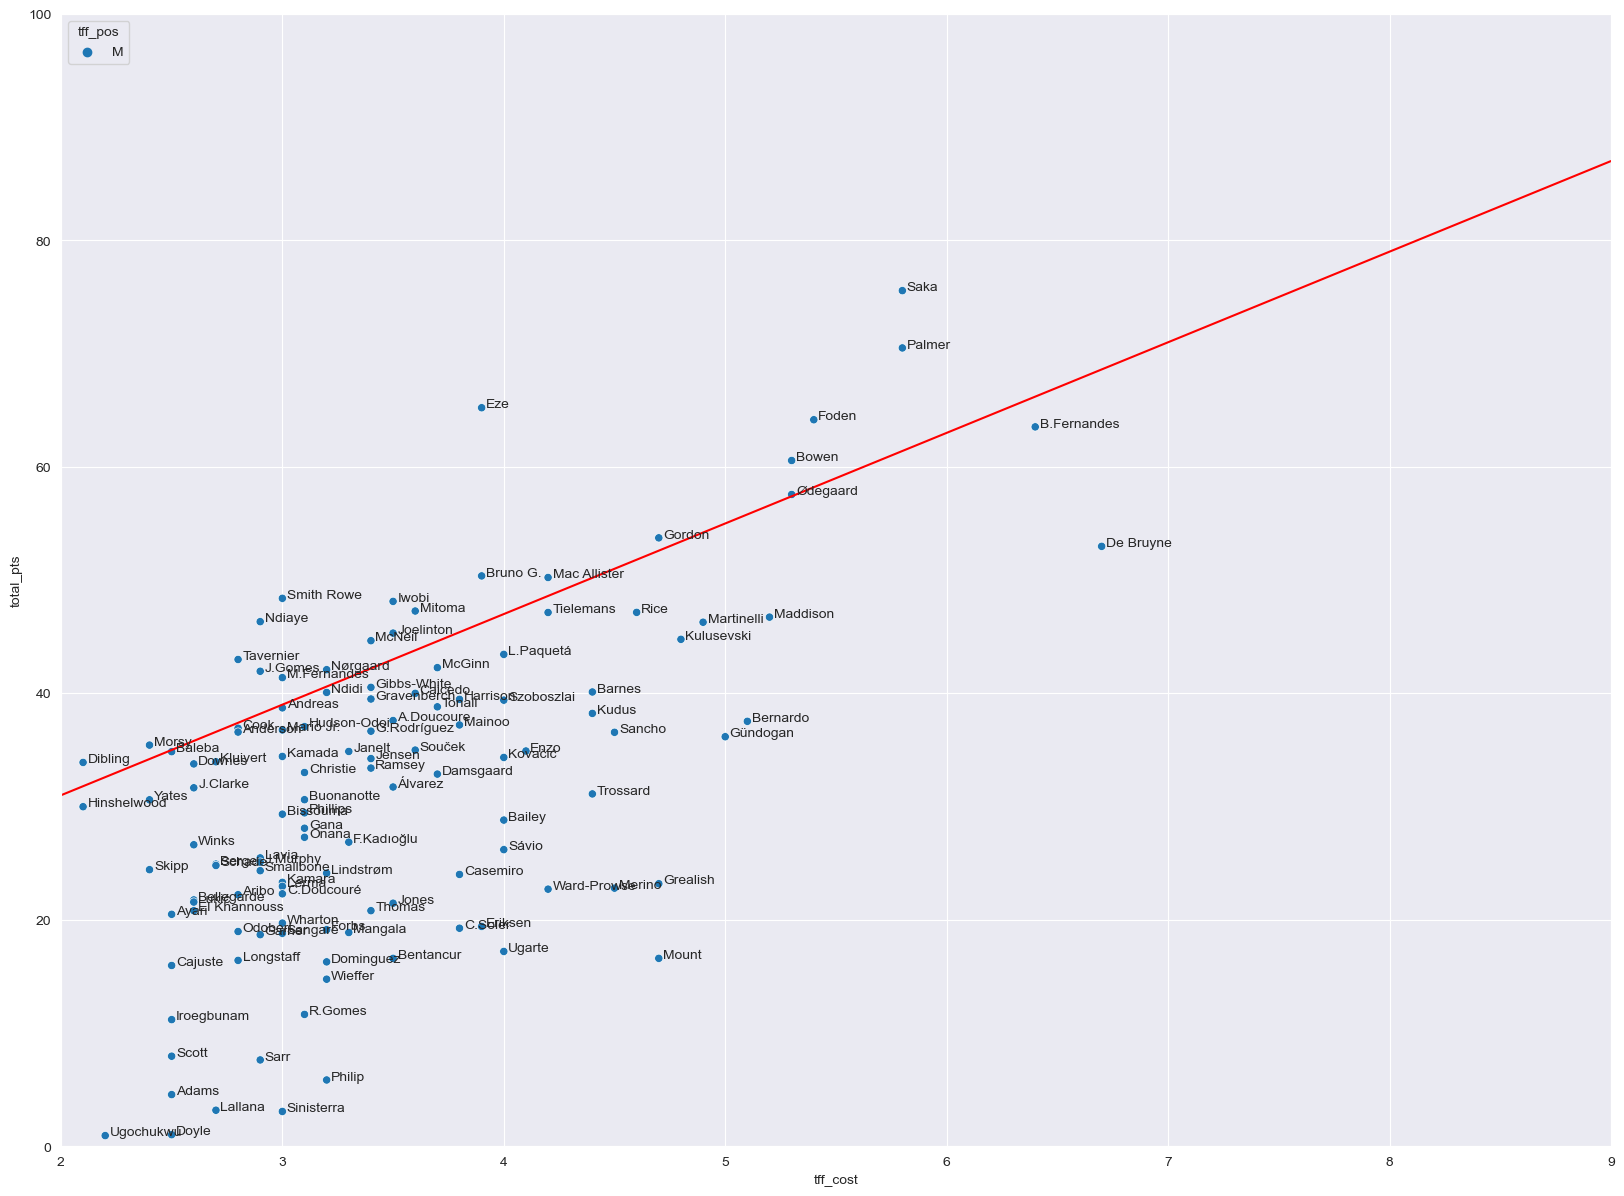

In [32]:
plt.rcParams['figure.figsize'] = [20, 15]
plt.rcParams['figure.dpi'] = 100

sns.set_style("darkgrid")
ev_df_1 = ev_df.copy()
ev_df_1 = ev_df_1.loc[ev_df_1['total_pts']>0]

## Uncomment lines to focus on specific positions
# ev_df_1 = ev_df_1.loc[ev_df_1['tff_pos']!='G']
ev_df_1 = ev_df_1.loc[ev_df_1['tff_pos']!='D']
ev_df_1 = ev_df_1.loc[ev_df_1['tff_pos']!='M']
ev_df_1 = ev_df_1.loc[ev_df_1['tff_pos']!='F']

ax = sns.scatterplot(x=ev_df_1['tff_cost'], y=ev_df_1['total_pts'], hue=ev_df_1['tff_pos'])
sns.move_legend(ax, 'upper left')
for index, row in ev_df_1.iterrows():
     ax.text(row['tff_cost']+.02, row['total_pts'], str(row['player']))

ax.set_xlim(2, 9)
ax.set_ylim(0, 100)
# Add a value line by setting parameters and uncommenting the following lines
X_plot = np.linspace(2, 9, 100)
Y_plot = 8*X_plot+15
ax.plot(X_plot, Y_plot, color='r')